## Load Dataset

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm 
import os
import scipy.signal

In [33]:
folder = 'data/Task1/train/'
file_list = os.listdir(folder)
for i in tqdm(range(int(len(file_list)/2))):

    src, _ = os.path.splitext(file_list[i * 2])
    dst = f'{i + 1:08}'
    
    for ext in ['.jpg', '.txt']:
        os.rename(folder + src + ext, folder + dst + ext)
    


In [258]:
## Load img #17
for n_img in range(1, 40000):
#     n_img = 193
#     img = plt.imread(f'data/{n_img:08}.jpg') / 255
    text = open(f'data/{n_img:08}.txt').readlines()[0]
    if ' ' in text:
        print(n_img)
#     plt.figure(figsize=(32, 16))
#     plt.axis('off')
#     plt.imshow(img, cmap='gray')
#     plt.show()
#     print(text)

KeyboardInterrupt: 

In [260]:
' ' in 'adsada'

False

16


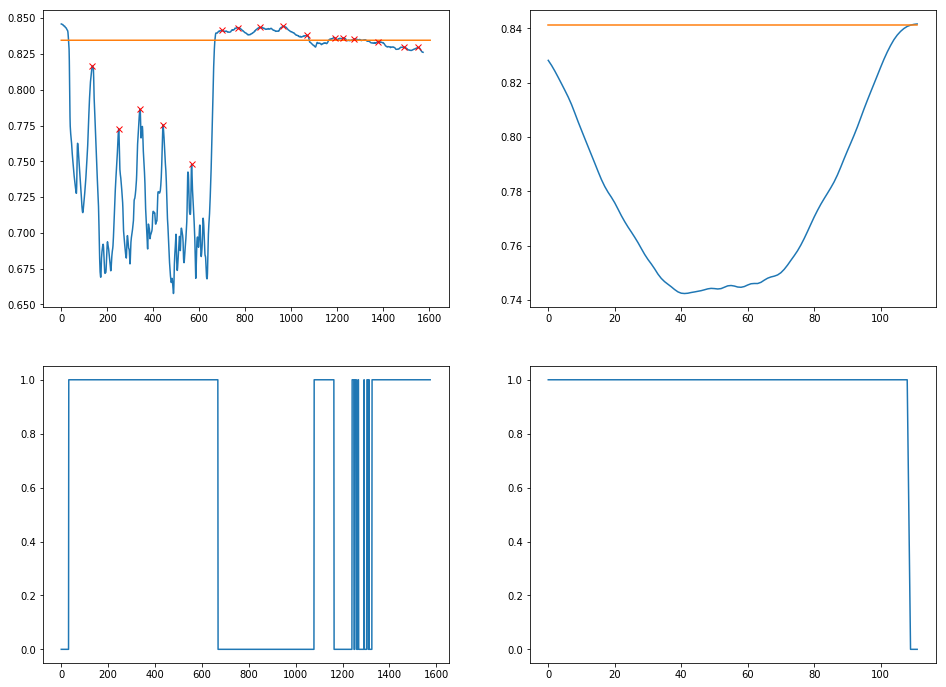

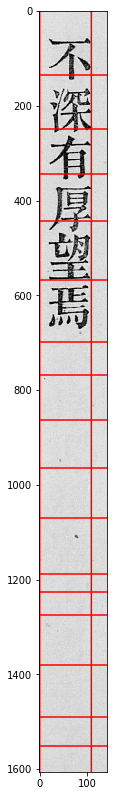

In [248]:
## processing

# compute profiles
v_profile = np.mean(img, axis=1)
h_profile = np.mean(img, axis=0)

# smoothing
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

v_profile_smooth = moving_average(v_profile, 32)
h_profile = moving_average(h_profile, 32)


# cutoff
v_cut = np.quantile(v_profile, 0.60)
h_cut = np.quantile(v_profile, 0.84)
v_profile_bin = np.array(v_profile_smooth < v_cut, dtype=int)
h_profile_bin = np.array(h_profile < h_cut, dtype=int)
# v_peaks = scipy.signal.find_peaks(-moving_average(v_profile, 32))
v_peaks = scipy.signal.argrelextrema(v_profile_smooth, np.greater, order=32)[0]
print(v_peaks.shape[0])

# draw profiles
fig, ax = plt.subplots(2,2)
fig.set_size_inches((16, 12))

ax[0][0].plot(v_profile_smooth)
ax[0][0].plot([v_cut] * v_profile.shape[0])
ax[0][0].plot(v_peaks, v_profile_smooth[v_peaks], 'rx')
ax[0][1].plot(h_profile)
ax[0][1].plot([h_cut] * h_profile.shape[0])

ax[1][0].plot(v_profile_bin)
ax[1][1].plot(h_profile_bin)

fig.show()

# boxes
plt.figure(figsize=(img.shape[0]//10, img.shape[1]//10))
# img_boxed[v_profile_bin, :] = 0
# img_boxed[:, h_profile_bin] = 0
plt.imshow(img, cmap='gray')

v_delimiters = np.argwhere(np.bitwise_xor(np.roll(v_profile_bin, 1), v_profile_bin))
h_delimiters = np.argwhere(np.bitwise_xor(np.roll(h_profile_bin, 1), h_profile_bin))

for p in v_peaks:
    plt.plot(np.arange(img.shape[1]), [p] * img.shape[1], 'r')

# for d in v_delimiters:
#     plt.plot(np.arange(img.shape[1]), [d] * img.shape[1], 'r')
for d in h_delimiters:
    plt.plot([d] * img.shape[0], np.arange(img.shape[0]), 'r')
# plt.plot( [v_profile_bin == 0] * )
# plt.plot( [h_profile_bin == 0] * img.shape[1])

# print(img_boxed)
plt.show()

In [218]:
print(h_cut)

0.8285259838201013


In [229]:
print(h_delimiters)

[30]


In [226]:
print(h_profile_bin)
print(np.roll(h_profile_bin, 1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]


In [227]:
print(np.bitwise_xor(h_profile_bin, np.roll(h_profile_bin, 1)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


-90.1875
-138
-44


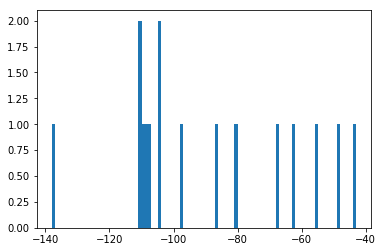

In [197]:
freq = (v_peaks - np.roll(v_peaks, -1))[:-1]
print(np.mean(freq))
print(np.min(freq))
print(np.max(freq))

plt.hist(freq, bins=np.arange(np.min(freq), np.max(freq) + 2))
plt.show()

In [158]:
scipy.signal.find_peaks(v_profile)

(array([   1,    5,    8,   12,   16,   20,   24,   29,   33,   37,   40,
          51,   70,   76,   83,   89,   96,  101,  104,  111,  113,  117,
         122,  124,  128,  133,  144,  154,  159,  164,  177,  183,  188,
         195,  206,  218,  222,  229,  236,  245,  249,  259,  274,  278,
         285,  295,  300,  308,  313,  318,  320,  329,  336,  343,  348,
         359,  363,  365,  387,  393,  398,  406,  410,  418,  421,  427,
         432,  448,  455,  457,  461,  472,  476,  483,  485,  491,  503,
         508,  510,  524,  547,  553,  563,  574,  576,  578,  585,  598,
         605,  608,  611,  617,  625,  646,  650,  656,  671,  676,  703,
         707,  711,  716,  722,  732,  736,  743,  751,  755,  758,  762,
         770,  774,  791,  796,  803,  816,  819,  830,  836,  855,  864,
         881,  891,  895,  900,  902,  908,  917,  928,  936,  946,  949,
         965,  973,  978,  982,  987,  991,  994, 1000, 1017, 1024, 1031,
        1034, 1040, 1042, 1046, 1048, 

## Segment Images

## Model

In [1]:
from keras.models import Model
from keras.layers import (
        Input,
        Flatten,
        Dense,
        ZeroPadding2D,
        Conv2D,
        Activation,
        MaxPooling2D,
        BatchNormalization)
from keras.layers.advanced_activations import LeakyReLU

# https://github.com/angzhou/anchor

Using TensorFlow backend.
